In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 3
setup_one_gpu(GPU)

Picking GPU 3


In [2]:
import sys
import numpy as np
import os.path as osp
import tensorflow as tf
import glob
import matplotlib.pylab as plt

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf


from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id
from tf_lab.autopredictors.scripts.virt_scan_data import plotting_default_params


from general_tools.notebook.tf import reset_tf_graph                                                  
from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k, indices_in_iterable


from geo_tool import Point_Cloud

from tf_lab.nips.shape_net import pc_loader as sn_pc_loader

from tf_lab.autopredictors.exploration import latent_embedding_of_entire_dataset

from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs
from sklearn.neighbors import NearestNeighbors

from general_tools.plotting import stack_images_horizontally, stack_images_in_square_grid

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
n_pc_samples = 2048
experiment_name = 'all_snc_rotated_conv_arch_2048pts_emd'
# experiment_name = class_name + '_conv_arch_1_2048pts_emd'
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
train_dir = osp.join(top_data_dir, 'OUT/models/nips/vanilla_ae/')
train_dir = osp.join(train_dir, experiment_name)
conf = Conf.load(osp.join(train_dir, 'configuration'))
conf.n_output = conf.n_input
reset_tf_graph()

conf.allow_gpu_growth = True
ae = PointNetAutoEncoder(experiment_name, conf)
saved_epochs = read_saved_epochs(conf.train_dir)
last_epoch = saved_epochs[-1]

ae.restore_model(conf.train_dir, last_epoch, verbose=True)

Model restored in epoch 1900.


In [78]:
class_name = raw_input('Give me the class type.\n').lower()
syn_id = shape_net_category_to_synth_id()[class_name]
print syn_id

Give me the class type.
bench
02828884


In [47]:
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
full_pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_samples))

full_pclouds_path = osp.join(full_pclouds_path, syn_id)

train_dir = osp.join(top_data_dir, 'OUT/models/nips/vanilla_ae/')
train_dir = osp.join(train_dir, experiment_name)

In [48]:
full_file_names = pio.load_filenames_of_input_data(full_pclouds_path, '.ply')
full_pclouds, full_model_names, full_syn_ids = pio.load_crude_point_clouds(file_names=full_file_names,\
                                                                           n_threads=40, loader=sn_pc_loader)
print '%d files containing complete point clouds were found.' % (len(full_pclouds), )

model_unames = full_model_names + '_' + full_syn_ids
train_data = PointCloudDataSet(full_pclouds, labels=full_model_names, init_shuffle=False)

1816 files containing complete point clouds were found.


In [49]:
_, latent_emb, _ = latent_embedding_of_entire_dataset(train_data, ae, conf)
n_objects = train_data.num_examples

In [74]:
import matplotlib.pyplot as plt
from geo_tool import Point_Cloud

in_u_sphere_plotting = {'chair': True, 'airplane': False, 'cabinet': False, 'car': False, 'lamp': True, 'sofa': True, 'table': True, 'vessel': False}

azimuth_angles = {'chair': -50, 'airplane': 0, 'cabinet': -40, 'car': -60, 'lamp': 0, 'sofa': -60, 'table': 60, 'vessel': -60}

plotting_color = {'chair': 'g', 'airplane': 'b', 'cabinet': 'orange', 'car': 'r', 'lamp': 'yellow', 'sofa': 'magenta', 'table': [0.7, .45, 0], 'vessel': [0, 0.6, 1]}

from tf_lab.nips.data_sets.shape_net import shape_net_core_synth_id_to_category

def plotting_default_params(category):
    kwdict = {}
    kwdict['in_u_sphere'] = True
    kwdict['azim'] = 45
    try:
        kwdict['azim'] = azimuth_angles[category]
        kwdict['color'] = plotting_color[category]
    except:
        pass
    return kwdict


def plot_interpolations(inter_clouds, grid_size, fig_size=(50, 50), plot_conf={}):
    fig = plt.figure(figsize=fig_size)
    c = 1
    for cloud in inter_clouds:
        plt.subplot(grid_size[0], grid_size[1], c, projection='3d')
        plt.axis('off')
        ax = fig.axes[c - 1]
        Point_Cloud(points=cloud).plot(axis=ax, show=False, **plot_conf)
        c += 1
    return fig

In [79]:
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
full_pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_samples))

class_name_2 = raw_input('Give me the class type.\n').lower()
syn_id_2 = shape_net_category_to_synth_id()[class_name_2]
print syn_id_2

full_pclouds_path = osp.join(full_pclouds_path, syn_id_2)

full_file_names_2 = pio.load_filenames_of_input_data(full_pclouds_path, '.ply')
full_pclouds_2, full_model_names_2, full_syn_ids_2 = pio.load_crude_point_clouds(file_names=full_file_names_2,\
                                                                           n_threads=40, loader=sn_pc_loader)

print '%d files containing complete point clouds were found.' % (len(full_pclouds_2), )
model_unames_2 = full_model_names_2 + '_' + full_syn_ids_2
train_data_2 = PointCloudDataSet(full_pclouds_2, labels=full_model_names_2, init_shuffle=False)

_, latent_emb_2, _ = latent_embedding_of_entire_dataset(train_data_2, ae, conf)
n_objects_2 = train_data_2.num_examples

Give me the class type.
sofa
04256520
3173 files containing complete point clouds were found.


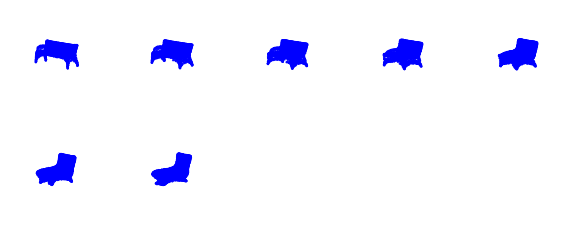

In [93]:
n_interpolants = 5
id1 = np.random.randint(0, n_objects)
id2 = np.random.randint(0, n_objects_2)

c1 = shape_net_core_synth_id_to_category[full_syn_ids[id1]]
c1 = plotting_default_params(c1)
c2 = shape_net_core_synth_id_to_category[full_syn_ids_2[id2]]
c2 = plotting_default_params(c2)

inter_results = ae.interpolate(full_pclouds[id1], full_pclouds_2[id2], 5)
fig = plot_interpolations(inter_results, (5,5), fig_size=(10,10), plot_conf=c1);

In [94]:
out_inter_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/nips/interpolations/'
folder = class_name + '_' + class_name_2 + '_emd_epoch_' + str(last_epoch)
save_tag = model_unames[id1] + '_' + model_unames_2[id2]
out_d = create_dir(osp.join(out_inter_dir, folder, save_tag))

fig.savefig(osp.join(out_d, 'interpolations.png'))

for i in range(n_interpolants+2):
    np.savetxt(osp.join(out_d, str(i) + '_inter.txt'), inter_results[i])
    

# SHAPE ANALOGIES

In [12]:
_, latent_emb, _ = latent_embedding_of_entire_dataset(train_data, ae, conf)
nn = NearestNeighbors(n_neighbors=2).fit(latent_emb)

In [15]:
# id1 = np.random.randint(0, n_objects)
# id2 = np.random.randint(0, n_objects)
# id3 = np.random.randint(0, n_objects)

triplet = [9, 4, 3]

diff = latent_emb[triplet[0]] - latent_emb[triplet[1]]

target = latent_emb[triplet[2]] + diff

distance, index = nn.kneighbors(target.reshape(1, -1))

triplet.append(index[0][1])
print triplet, distance

top_image_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/Meshes/Shape_Net_Core/2015_Summer_OUT/Images/' + syn_id
image_setting = 'image_p020_t315_r005.png'
triplet_im_files = [osp.join(top_image_dir, i, image_setting) for i in full_model_names[triplet]]

stack_images_horizontally(triplet_im_files)
# stack_images_in_square_grid(triplet_im_files)
# stack_images_horizontally_2(triplet_im_files)

[9, 4, 3, 308] [[ 2.03863633  2.07982047]]


<PIL.Image.Image image mode=RGBA size=3840x540 at 0x7FE9C9994A70>

In [23]:
from PIL import Image
def stack_images_horizontally_2(file_names, save_file=None):
    ''' Opens the images corresponding to file_names and
    creates a new image stacking them horizontally.
    '''
    images = map(Image.open, file_names)
    widths, heights = zip(*(i.size for i in images))
    total_width = sum(widths)
    max_height = max(heights)
    new_im = Image.new('RGBA', (total_width, max_height))

    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset, 0))
        x_offset += im.size[0]
    if save_file is not None:
        new_im.save(save_file)
    return new_im